In [1]:
from sqlalchemy import create_engine
import time
from datetime import timedelta, date, datetime
import numpy as np
import pandas as pd
import warnings
import pandas as pd
from fbprophet import Prophet
warnings.simplefilter('ignore')
from sklearn import metrics

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase3.csv to Global DataBase3.csv
Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv


In [3]:
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True, dayfirst=True)

df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst=True)

columns = ['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns : 
    df[column] = df2[column].resample("D").mean()

columns = ['Electricity Consumption (MWh)']
for column in columns : 
    df[column] = df2[column].resample("D").sum()
    
df = df.sort_index()


#Handeling global outliers
GlobalOutliers =  []
for i in range(0):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()

In [4]:
df = df.reset_index(level=0)
df = df[["Price - PT [€/MWh]", "datetime_per_day"]]
df.columns = ['y', 'ds']
df

,y,ds
0,51.421739,2017-01-01
1,58.878333,2017-01-02
2,65.245833,2017-01-03
3,66.700417,2017-01-04
4,66.858750,2017-01-05
...,...,...
1883,259.459167,2022-03-01
1884,254.469583,2022-03-02
1885,284.066667,2022-03-10
1886,284.066667,2022-03-11


In [5]:
# split into train and test sets 
size = int(len(df) * 0.8)
train, test = df[0:size], df[size:len(df)]

m = Prophet(interval_width=0.95)
start_time = time.time()
model = m.fit(train)
exec_time = time.time()-start_time

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


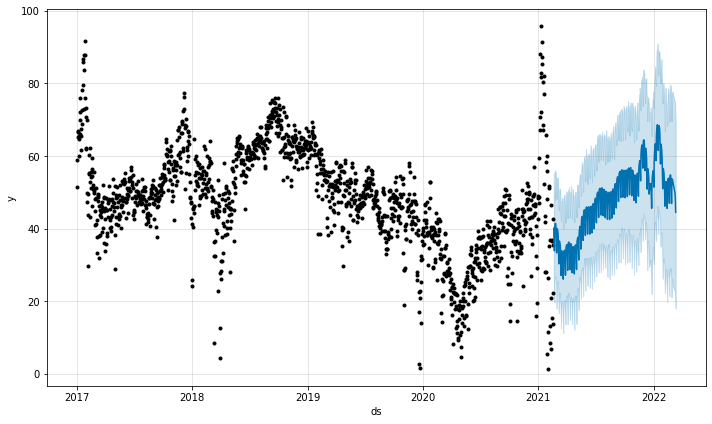

In [6]:
forecast = m.predict(test)
plot1 = m.plot(forecast)

In [7]:
inv_y = test['y']
inv_yhat = forecast['yhat']

#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('Execution Time:', '%.5f' %  exec_time)

Mean Absolute Error: 87.49405580873275
Mean Squared Error: 11753.237002435168
Root Mean Squared Error: 108.41234709402416
Coefficient of Variance: 80.49896990801766
R2: -1.23677390324317
Execution Time: 1.01287
